In [1]:
# First we need to import all of the packages we will be using!
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
#NFKB - p50 dimer model

def NFKB_model(states, t, NFKB_on1, NFKB_off1, NFKB_on2, NFKB_off2, NFKB_amp):
    # Our "states" list has the state variables in the following order:
    # pr (inactive promoter), pr_a (active promoter), p50 (p50:p50 dimer)
    pr = states[0]
    pr_a = states[1]
    p50 = states[2]
    
    # delayed variables (pr_a_tau is only one needed)
    pr_a_tau = delay_pr_a(t)
    
    # TF (transcription factor) dynamics
    if (t > NFKB_on1 and t < NFKB_off1) or (t > NFKB_on2 and t < NFKB_off2):
        NFKB = NFKB_amp
    else:
        NFKB = 0
   
    # Hill Equation
    H_n = NFKB/(NFKB + Kd1)
    H_p = p50/(p50 + Kd2)
    H = H_n * (1 - H_p)
    
    ### implement the change equations
    pr_prime = -k_a*H*pr + k_d*pr_a 
    pr_a_prime = k_a*H*pr - k_d*pr_a
    p50_prime = k_syn*pr_a_tau - k_deg*p50
    ###
    
    statesprime = [pr_prime, pr_a_prime, p50_prime]
    return statesprime

In [3]:
#delay helper functions

#these helper functions search through the ODE solution from the previous iteration 
#to give approximations of pr_a_tau as needed

def delay_pr_a(t_search):
    index = np.argmin(abs(t_search-t_index))
    return soln_hist[index, 1]

In [81]:
#Simulation of NFKB-p50:p50 model

#initial conditions
pr0 = 1 #(uM)
pr_a0 = 0
p50_0 = 0

#parameters
Kd1 = 0.1
Kd2 = 0.1
k_a = 0.2     #(min)^-1
k_d = 0.05    #(min)^-1
k_syn = 0.05   #uM(min^1)
k_deg = 0.08 #(min)^-1
tau = 25      # min

#NFKB activation
NFKB_on1_time = 0
NFKB_off1_time = 60
NFKB_on2_time = 120
NFKB_off2_time = 180
NFKB_amplitude = 1

t_final=np.array([])
soln_final = np.empty((0, 3))
states0 = [pr0, pr_a0, p50_0]
soln_hist = np.tile(states0, (1001, 1))

iterations = 25

for i in range(iterations):
    # solve ODE in one period of tau, using saved values of delayed variables
    t_index = np.linspace(0,tau,1001)
    solution = odeint(NFKB_model,states0,t_index, args=(NFKB_on1_time, NFKB_off1_time, NFKB_on2_time, NFKB_off2_time, NFKB_amplitude))
    
    # append new solution to array of old solution values
    t_final = np.append(t_final, (t_index[0:1000]+i*tau))
    soln_final = np.vstack((soln_final, solution[0:1000, :]))
    
    #update IFNAR on/off times, initial conditions, and solution history for next calculation
    NFKB_on1_time = NFKB_on1_time - tau
    NFKB_off1_time = NFKB_off1_time - tau
    NFKB_on2_time = NFKB_on2_time - tau
    NFKB_off2_time = NFKB_off2_time - tau
    states0 = solution[1000, :]
    soln_hist = solution

In [82]:
#Checking Model Implementation
#checks only work on default parameter values
print("Checks on Model Implementation:")
print("For each of the following lines ensure that your value on the right matches that on the left")
print(0.5358304341185932, soln_final[2000, 0])
print(0.46416956588140657, soln_final[2000, 1])
print(0.7302990673189521, soln_final[2000, 2])

Checks on Model Implementation:
For each of the following lines ensure that your value on the right matches that on the left
0.5358304341185932 0.48178735728017985
0.46416956588140657 0.5182126427198159
0.7302990673189521 0.389682066283035


In [83]:
# plotting helper functions
def box_fxn(on1, off1, on2, off2, amp, end):
    return np.array([0, on1, on1, off1, off1, on2, on2, off2, off2, end]), np.array([0, 0, amp, amp, 0, 0, amp, amp, 0, 0])

Text(0.5, 1.0, 'model ouput')

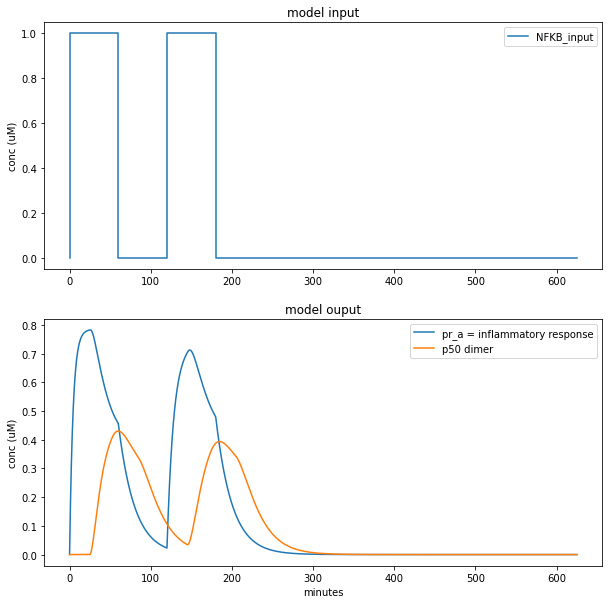

In [84]:
#Plot Dynamics
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
time,signal = box_fxn(NFKB_on1_time+(25*iterations), NFKB_off1_time+(25*iterations), NFKB_on2_time+(25*iterations), NFKB_off2_time+(25*iterations), NFKB_amplitude, 25*iterations)
plt.plot(time, signal, label = "NFKB_input")
plt.ylabel('conc (uM)')
plt.legend()
plt.title("model input")
plt.subplot(2,1,2)
lineObjects=plt.plot(t_final, soln_final[:, 1:])
plt.xlabel('minutes')
plt.ylabel('conc (uM)')
plt.legend(lineObjects, ('pr_a = inflammatory response', 'p50 dimer'))
plt.title("model ouput")

In [86]:
#simple IFN model

def IFN_model(states, t, IFN_on1, IFN_off1, IFN_on2, IFN_off2, IFN_amp):
    # Our "states" list has the state variables in the following order:
    # ISGF3, ISGF3p (inactive ISGF3, active ISGF3)
    ISGF3 = states[0]
    ISGF3p = states[1]
    
    # IFN (interferon) dynamics
    if (t > IFN_on1 and t < IFN_off1) or (t > IFN_on2 and t < IFN_off2):
        IFN = IFN_amp
    else:
        IFN = 0
        
    # delayed variables (ISGF3p_tau, is only one needed)
    ISGF3p_tau = delay_ISGF3p(t)
   
    # Hill Term
    H = ISGF3p_tau/(ISGF3p_tau + Kd)
    
    ### implement the change equations
    ISGF3_prime = k1_syn*(1+H) - k1_deg*ISGF3 - k_a*ISGF3*IFN + k_d*ISGF3p
    ISGF3p_prime = -k2_deg*ISGF3p + k_a*IFN*ISGF3 - k_d*ISGF3p
    ###
    
    statesprime = [ISGF3_prime, ISGF3p_prime]
    return statesprime

In [87]:
#delay helper functions

#these helper functions search through the ODE solution from the previous iteration 
#to give approximations of ISGF3p_tau as needed

def delay_ISGF3p(t_search):
    index = np.argmin(abs(t_search-t_index))
    return soln_hist[index, 1]

In [117]:
#Simulation of simple IFN model

#initial conditions
ISGF30 = 10 #(nM)
ISGF3p0 = 0

#parameters
k1_syn = 0.1  #nM(min^-1)
k1_deg = 0.01 #(min)^-1
k2_deg = 0.01
k_a = 0.2     #(nM*min)^-1
k_d = 0.05    #(min)^-1
Kd = 0.1
tau = 25      # min

#IFN activation
IFN_on1_time = 0
IFN_off1_time = 100
IFN_on2_time = 0
IFN_off2_time = 0
IFN_amplitude = 1

t_final=np.array([])
soln_final = np.empty((0, 2))
states0 = [ISGF30, ISGF3p0]
soln_hist = np.tile(states0, (1001, 1))

iterations = 20

for i in range(iterations):
    # solve ODE in one period of tau, using saved values of delayed variables
    t_index = np.linspace(0,tau,1001)
    solution = odeint(IFN_model,states0,t_index, args=(IFN_on1_time, IFN_off1_time, IFN_on2_time, IFN_off2_time, IFN_amplitude))
    
    # append new solution to array of old solution values
    t_final = np.append(t_final, (t_index[0:1000]+i*tau))
    soln_final = np.vstack((soln_final, solution[0:1000, :]))
    
    #update IFN on/off times, initial conditions, and solution history for next calculation
    IFN_on1_time = IFN_on1_time - tau
    IFN_off1_time = IFN_off1_time - tau
    IFN_on2_time = IFN_on2_time - tau
    IFN_off2_time = IFN_off2_time - tau
    states0 = solution[1000, :]
    soln_hist = solution

In [118]:
#Checking Model Implementation
#checks only work on default parameter values
print("Checks on Model Implementation:")
print("For each of the following lines ensure that your value on the right matches that on the left")
print(2.8790276213841497, soln_final[400, 0])
print(7.120972378615856, soln_final[400, 1])

Checks on Model Implementation:
For each of the following lines ensure that your value on the right matches that on the left
2.8790276213841497 2.8790275510330896
7.120972378615856 7.120972448966916


Text(0.5, 1.0, 'model ouput')

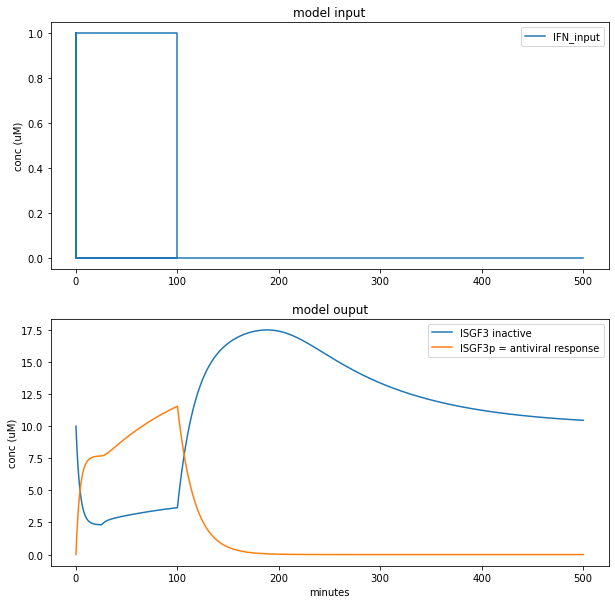

In [119]:
#Plot Dynamics
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
time,signal = box_fxn(IFN_on1_time+(25*iterations), IFN_off1_time+(25*iterations), IFN_on2_time+(25*iterations), IFN_off2_time+(25*iterations), IFN_amplitude, 25*iterations)
plt.plot(time, signal, label = "IFN_input")
plt.ylabel('conc (uM)')
plt.legend()
plt.title("model input")
plt.subplot(2,1,2)
lineObjects=plt.plot(t_final, soln_final)
plt.xlabel('minutes')
plt.ylabel('conc (uM)')
plt.legend(lineObjects, ('ISGF3 inactive', 'ISGF3p = antiviral response'))
plt.title("model ouput")

In [129]:
#complete IFN model

def V_IFN_model(states, t, V_on1, V_off1, V_on2, V_off2, V_amp):
    # Our "states" list has the state variables in the following order:
    # ISGF3, ISGF3p, IRF37, IRF37p, IRF1, IFN (inactive ISGF3, active ISGF3, inactive IRF3/7, active IRF3/7, active IRF1, interferon)
    ISGF3 = states[0]
    ISGF3p = states[1]
    IRF37 = states[2]
    IRF37p = states[3]
    IRF1 = states[4]
    IFN = states[5]
    
    # V (virus) dynamics
    if (t > V_on1 and t < V_off1) or (t > V_on2 and t < V_off2):
        V = V_amp
    else:
        V = 0
        
    # delayed variables (ISGF3p_tau, IRF37p_tau, and IRF1_tau, are only those needed)
    ISGF3p_tau = delay_ISGF3p(t)
    IRF37p_tau = delay_IRF37p(t)
    IRF1_tau = delay_IRF1(t)
   
    # Hill Terms
    H = ISGF3p_tau/(ISGF3p_tau + Kd1)
    H_or = 1 - ((Kd2/(Kd2+IRF37p_tau))*(Kd3/(Kd3+IRF1_tau)))
    
    ### implement the change equations
    ISGF3_prime = k1_syn*(1+H) - k1_deg*ISGF3 - k_a1*IFN*ISGF3 + k_d1*ISGF3p
    ISGF3p_prime = -k2_deg*ISGF3p + k_a1*IFN*ISGF3 - k_d1*ISGF3p 
    IRF37_prime = k3_syn*(1+H) -k3_deg*IRF37 - k_a2*IRF37*V + k_d2*IRF37p
    IRF37p_prime = -k4_deg*IRF37p + k_a2*IRF37*V - k_d2*IRF37p
    IRF1_prime = k5_syn*H - k5_deg*IRF1 
    IFN_prime = k6_syn*H_or - k6_deg*IFN
    ###
    
    statesprime = [ISGF3_prime, ISGF3p_prime, IRF37_prime, IRF37p_prime, IRF1_prime, IFN_prime ]
    return statesprime

In [130]:
#delay helper functions

#these helper functions search through the ODE solution from the previous iteration 
#to give approximations of ISGF3p_tau, IRF37p_tau, and IRF1_tau as needed

def delay_ISGF3p(t_search):
    index = np.argmin(abs(t_search-t_index))
    return soln_hist[index, 1]

def delay_IRF37p(t_search):
    index = np.argmin(abs(t_search-t_index))
    return soln_hist[index, 3]

def delay_IRF1(t_search):
    index = np.argmin(abs(t_search-t_index))
    return soln_hist[index, 4]

In [137]:
#Simulation of complete IFN model

#initial conditions
ISGF30 = 10 #(nM)
ISGF3p0 = 0
IRF370 = 10
IRF37p0 = 0
IRF10 = 0
IFN0 = 0

#parameters
k1_syn = 0.1  #nM(min^-1)
k1_deg = 0.01 #(min)^-1
k2_deg = 0.01
k3_syn = 0.1  
k3_deg = 0.01 
k4_deg = 0.01
k5_syn = 0.1  
k5_deg = 0.01 
k6_syn = 0.1  
k6_deg = 0.01
k_a1 = 0.2     #(nM*min)^-1
k_d1 = 0.05    #(min)^-1
k_a2 = 0.2     
k_d2 = 0.05    
Kd1 = 0.1
Kd2 = 0.1
Kd3 = 0.1
tau = 25      # min

#viral activation
V_on1_time = 0
V_off1_time = 10
V_on2_time = 1000
V_off2_time = 1010
V_amplitude = 1

t_final=np.array([])
soln_final = np.empty((0, 6))
states0 = [ISGF30, ISGF3p0, IRF370, IRF37p0, IRF10, IFN0]
soln_hist = np.tile(states0, (1001, 1))

iterations = 20

for i in range(iterations):
    # solve ODE in one period of tau, using saved values of delayed variables
    t_index = np.linspace(0,tau,1001)
    solution = odeint(V_IFN_model,states0,t_index, args=(V_on1_time, V_off1_time, V_on2_time, V_off2_time, V_amplitude))
    
    # append new solution to array of old solution values
    t_final = np.append(t_final, (t_index[0:1000]+i*tau))
    soln_final = np.vstack((soln_final, solution[0:1000, :]))
    
    #update V on/off times, initial conditions, and solution history for next calculation
    V_on1_time = V_on1_time - tau
    V_off1_time = V_off1_time - tau
    V_on2_time = V_on2_time - tau
    V_off2_time = V_off2_time - tau
    states0 = solution[1000, :]
    soln_hist = solution

In [138]:
#Checking Model Implementation
#checks only work on default parameter values
print("Checks on Model Implementation:")
print("For each of the following lines ensure that your value on the right matches that on the left")
print(1.3342367233230394, soln_final[2000, 0])
print(12.957147386427966, soln_final[4000, 1])
print(2.8790276213841497, soln_final[400, 2])
print(7.120972378615856, soln_final[400, 3])
print(3.794056609229181, soln_final[4000, 4])
print(5.038355452623642, soln_final[4000, 5])

Checks on Model Implementation:
For each of the following lines ensure that your value on the right matches that on the left
1.3342367233230394 1.3342369722071357
12.957147386427966 12.957148245670236
2.8790276213841497 2.8790276403290833
7.120972378615856 7.1209723596709225
3.794056609229181 3.794056873963138
5.038355452623642 5.038359153346808


Text(0.5, 1.0, 'model ouput')

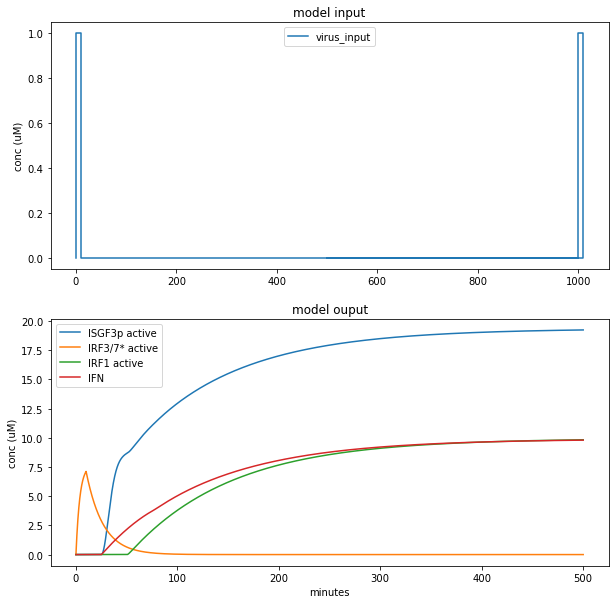

In [139]:
#Plot Dynamics
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
time,signal = box_fxn(V_on1_time+(25*iterations), V_off1_time+(25*iterations), V_on2_time+(25*iterations), V_off2_time+(25*iterations), V_amplitude, 25*iterations)
plt.plot(time, signal, label = "virus_input")
plt.ylabel('conc (uM)')
plt.legend()
plt.title("model input")
plt.subplot(2,1,2)
lineObjects=plt.plot(t_final, soln_final[:, [1, 3, 4, 5]])
plt.xlabel('minutes')
plt.ylabel('conc (uM)')
plt.legend(lineObjects, ('ISGF3p active', 'IRF3/7* active', 'IRF1 active', 'IFN'))
plt.title("model ouput")